## Use a CNN to Classify Dog Breeds using Transfer Learning

This is an alternative to Step 5 in the project where transfer learning is used to create a CNN that can identify dog breed from images. 

In addition to demonstrating transfer learning this example also uses image augmentation when extracting bottleneck features and training the new network.

### High Level Approach

The high level approach is as follows:

1. Extract the bottleneck features from InceptionV3 model
2. Train new network using the extracted bottleneck features
3. Use new model to make predictions

### Extract Bottleneck Features from InceptionV3 Model

In [1]:
# Import Python Libraries

import numpy as np
#import tensorflow as tf
import keras as keras
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint 
from keras.utils.np_utils import to_categorical
import math
import utility

Using TensorFlow backend.


The following is required to address a bug when using ImageDataGenerator and the InceptionV3 model. See [IOError: Image File is truncated](https://github.com/keras-team/keras/issues/5475) for details.

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
# Get the InceptionV3 model with the final fully-connected layers removed

from keras.applications.inception_v3 import InceptionV3
model = InceptionV3(include_top=False)
#model.summary()

In [4]:
augmentation_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

standard_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

In [5]:
# Use a data generator to run augmented images from the training dataset through the network.

train_generator = augmentation_datagen.flow_from_directory(
        'dogImages/train',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

number_of_train_samples = len(train_generator.filenames)
number_of_train_steps = int(math.ceil(number_of_train_samples / float(batch_size)))

train_bottleneck_features = model.predict_generator(train_generator, number_of_train_steps)

Found 6680 images belonging to 133 classes.


In [6]:
# Use a data generator to run augmented images from the validation dataset through the network

valid_generator = augmentation_datagen.flow_from_directory(
        'dogImages/valid',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

number_of_valid_samples = len(valid_generator.filenames)
number_of_valid_steps = int(math.ceil(number_of_valid_samples / float(batch_size)))

valid_bottleneck_features = model.predict_generator(valid_generator, number_of_valid_steps)

Found 835 images belonging to 133 classes.


In [7]:
# Use a data generator to run non-augmented images from the testing dataset through the network

test_generator = standard_datagen.flow_from_directory(
        'dogImages/test',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

number_of_test_samples = len(test_generator.filenames)
number_of_test_steps = int(math.ceil(number_of_test_samples / float(batch_size)))

test_bottleneck_features = model.predict_generator(test_generator, number_of_test_steps)

Found 836 images belonging to 133 classes.


In [8]:
# Save the bottleneck features to an .npz file

np.savez('bottleneck_features/dog_features_augmented_InceptionV3Data.npz', train=train_bottleneck_features, valid=valid_bottleneck_features, test=test_bottleneck_features)

### Train New Network using Extracted Bottleneck Features

In [9]:
# load the bottleneck features
bottleneck_features = np.load('bottleneck_features/dog_features_augmented_InceptionV3Data.npz')

In [10]:
# Define data generators for training

train_generator = augmentation_datagen.flow_from_directory(
        'dogImages/train',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

number_of_train_samples = len(train_generator.filenames)
number_of_train_classes = len(train_generator.class_indices)
number_of_train_steps = int(math.ceil(number_of_train_samples / float(batch_size)))

# get the bottleneck features
train_data = bottleneck_features['train']

# get class lables
train_labels = train_generator.classes

# convert to categorical vectors
train_labels = to_categorical(train_labels, num_classes=number_of_train_classes)

Found 6680 images belonging to 133 classes.


In [11]:
# Define data generators for validation

valid_generator = augmentation_datagen.flow_from_directory(
        'dogImages/valid',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

number_of_valid_samples = len(valid_generator.filenames)
number_of_valid_classes = len(valid_generator.class_indices)
number_of_valid_steps = int(math.ceil(number_of_valid_samples / float(batch_size)))

# get the bottleneck features
valid_data = bottleneck_features['valid']

# get class lables
valid_labels = valid_generator.classes

# convert to categorical vectors
valid_labels = to_categorical(valid_labels, num_classes=number_of_valid_classes)

Found 835 images belonging to 133 classes.


In [12]:
# Define data generators for testing

test_generator = standard_datagen.flow_from_directory(
        'dogImages/test',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

number_of_test_samples = len(test_generator.filenames)
number_of_test_classes = len(test_generator.class_indices)
number_of_test_steps = int(math.ceil(number_of_test_samples / float(batch_size)))

# get the bottleneck features
test_data = bottleneck_features['test']

# get class lables
test_labels = test_generator.classes

# convert to categorical vectors
test_labels = to_categorical(test_labels, num_classes=number_of_test_classes)

Found 836 images belonging to 133 classes.


In [13]:
# Define the new model

new_model = Sequential()

new_model.add(GlobalAveragePooling2D(input_shape=train_data.shape[1:]))

# final fully connected layer
new_model.add(Dense(number_of_train_classes, activation='softmax'))

new_model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


In [14]:
# Compile the model

new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [15]:
# Train the new model

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.InceptionV3.hdf5', verbose=1, save_best_only=True)

history = new_model.fit(train_data, train_labels, 
          validation_data=(valid_data, valid_labels),
          epochs=10, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 2s - loss: 2.0049 - acc: 0.5290 - val_loss: 1.3360 - val_acc: 0.6228
Epoch 2/10
6680/6680 [==============================] - 2s - loss: 0.8091 - acc: 0.7570 - val_loss: 1.3426 - val_acc: 0.6563
Epoch 3/10
6680/6680 [==============================] - 2s - loss: 0.5177 - acc: 0.8433 - val_loss: 1.2846 - val_acc: 0.6707
Epoch 4/10
6680/6680 [==============================] - 2s - loss: 0.3267 - acc: 0.9028 - val_loss: 1.2587 - val_acc: 0.6814
Epoch 5/10
6680/6680 [==============================] - 2s - loss: 0.2208 - acc: 0.9386 - val_loss: 1.3044 - val_acc: 0.6766
Epoch 6/10
6680/6680 [==============================] - 2s - loss: 0.1492 - acc: 0.9677 - val_loss: 1.2518 - val_acc: 0.6814
Epoch 7/10
6680/6680 [==============================] - 2s - loss: 0.1130 - acc: 0.9787 - val_loss: 1.2755 - val_acc: 0.6898
Epoch 8/10
6680/6680 [==============================] - 2s - loss: 0.0747 - ac

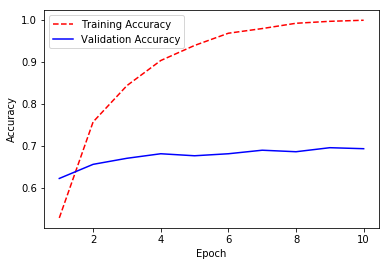

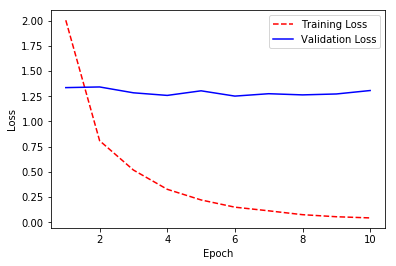

In [16]:
utility.plot_accuracy(history)
utility.plot_loss(history)

### Use New Model to Make Predictions

In [17]:
# load the model weights with the best validation loss
new_model.load_weights('saved_models/weights.best.InceptionV3.hdf5')

# get index of predicted dog breed for each image in test set
predictions = [np.argmax(new_model.predict(np.expand_dims(feature, axis=0))) for feature in test_data]

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_labels, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 80.9809%
